## Convective area as a function of time from CPOL, WRF

Creates plots of spread in area of convective regions vs time from CPOL, WRF

In [1]:
import pyart
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import glob
from copy import deepcopy
from netCDF4 import Dataset
from scipy import ndimage
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119 


Load all grids from computer

In [2]:
data_path = 'C:/Users/rjackson/Documents/data/multidop_grids/'
conv_strat_path = 'C:/Users/rjackson/Documents/data/conv_stratiform/'
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_dda_times(start_year, start_month, start_day,
                  start_hour, start_minute, end_year,
                  end_month, end_day, end_hour, 
                  end_minute, minute_interval=5):

    start_time = datetime(start_year,
                      start_month,
                      start_day,
                      start_hour,
                      start_minute,
                      )
    end_time = datetime(end_year,
                      end_month,
                      end_day,
                      end_hour,
                      end_minute,
                      )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
 
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path +
                      'cf_compliant_grid' +
                      year_str +
                      month_str +
                      day_str +
                      '*.nc')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-15:-3]
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[8:10]
        minute_str = date_str[10:12]
        second_str = '00'
             
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            0)
        time_list.append(cur_time)
        
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
   
    for times in time_list_sorted:         
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
                           
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_grid_from_dda(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path +
                    'cf_compliant_grid' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = pyart.io.read_grid(file_name_str)
    return radar

def get_conv_strat(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (conv_strat_path +
                     'cpol_conv_strat' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + '.nc')
    
    radar = Dataset(file_name_str)
    return radar

def get_conv_strat_wrf(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (conv_strat_path +
                     'conv_strat_wrf' +
                     year_str +
                     month_str +
                     day_str +
                     hour_str +
                     minute_str + 
                     second_str + '.nc')
    print(file_name_str)
    radar = Dataset(file_name_str)
    return radar

def area_conv(pixel_area, convective): 
    b_fld = np.zeros(convective.shape) 
    b_fld[np.where(convective == 2)] = 1.0 
    regions, labels = ndimage.label(b_fld)
    if(np.max(regions) > 1):
        A_convective = np.zeros(np.max(regions))
        for i in range(1,np.max(regions)):
                A_convective[i-1] = (len(np.where( regions == i)[0]) * pixel_area)   
    else:
        A_convective = 0
    return A_convective

def area_strat(pixel_area, convective): 
    b_fld = np.zeros(convective.shape) 
    b_fld[convective == 1] = 1.0 
    regions, labels = ndimage.label(b_fld)
    if(np.max(labels) > 1):
        A_stratiform = np.zeros(np.max(labels))
        for i in range(1,np.max(labels)):
            A_stratiform[i-1] = (len(np.where( regions == i)[0]) * pixel_area)   
    else:
        A_stratiform = 0
    return A_stratiform

In [3]:
times = get_dda_times(2006, 1, 20, 0, 1,
                      2006, 1, 20, 2, 58)
# Make sure start time = WRF start time

We are about to load grid files for 1 days
Looking for files with format C:/Users/rjackson/Documents/data/multidop_grids/cf_compliant_grid20060120*.nc


## Load convective-stratiform classification for each grid

C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120001000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120002000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120003000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120004000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120005000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120010000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120011000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120012000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120013000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120014000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120015000.nc
C:/Users/rjackson/Documents/data/conv_stratiform/conv_strat_wrf20060120020000.nc
C:/Users/rjackson/Documents/

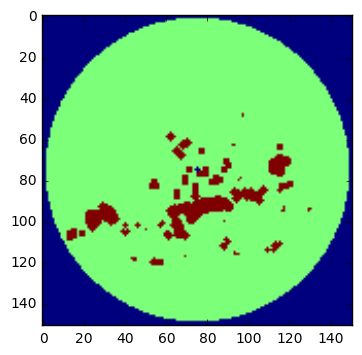

In [17]:
conv_area_obs = []
strat_area_obs = []
conv_area_wrf = []
strat_area_wrf = []
datenums = np.zeros(len(times))

i = 0
for rad_time in times:
    convective = get_conv_strat(rad_time)
    conv_area_obs.append(area_conv(1, convective.variables['strat_conv'][:]))
    strat_area_obs.append(area_strat(1, convective.variables['strat_conv'][:]))
    plt.imshow(convective.variables['strat_conv'])
    convective = get_conv_strat_wrf(rad_time)
    conv_area_wrf.append(area_conv(1, convective.variables['strat_conv'][:]))
    strat_area_wrf.append(area_strat(1, convective.variables['strat_conv'][:]))
    i = i + 1

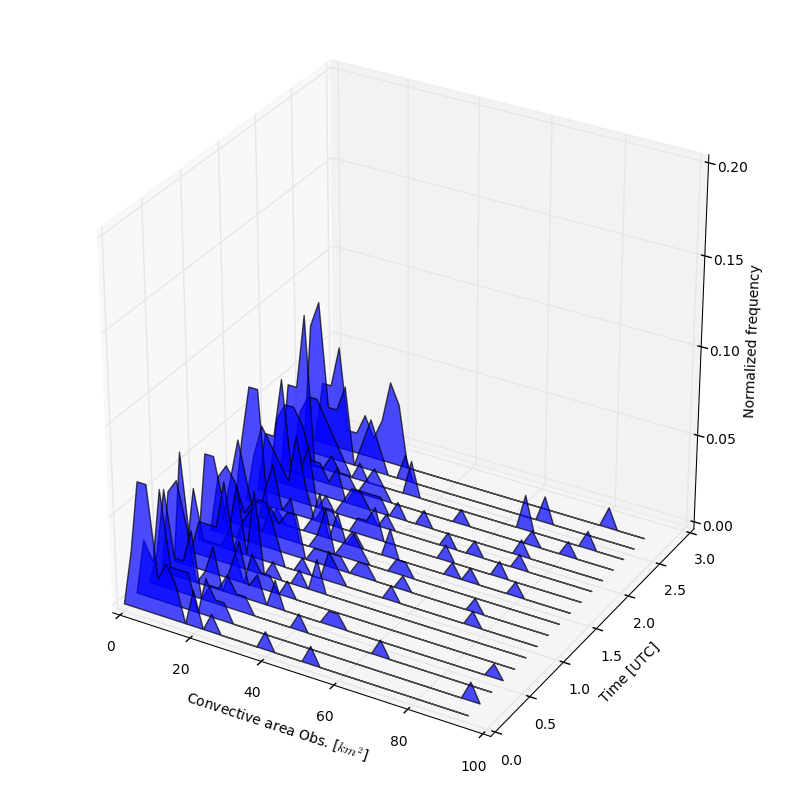

In [22]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = np.arange(0, 100, 2.5)
verts = []
zs = np.arange(0, len(times), 1.0)
i = 0
for z in zs:
    ys, bins = np.histogram(conv_area_obs[i], bins=xs, normed=True)
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))
    i = i + 1

poly = PolyCollection(verts)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs/6, zdir='y')

ax.set_xlabel('Convective area Obs. [$km^{2}$]')
ax.set_xlim3d(0, 100)
ax.set_ylabel('Time [UTC]')
ax.set_ylim3d(0, 3)
ax.set_zlabel('Normalized frequency')
ax.set_zlim3d(0, 0.2)

plt.show()

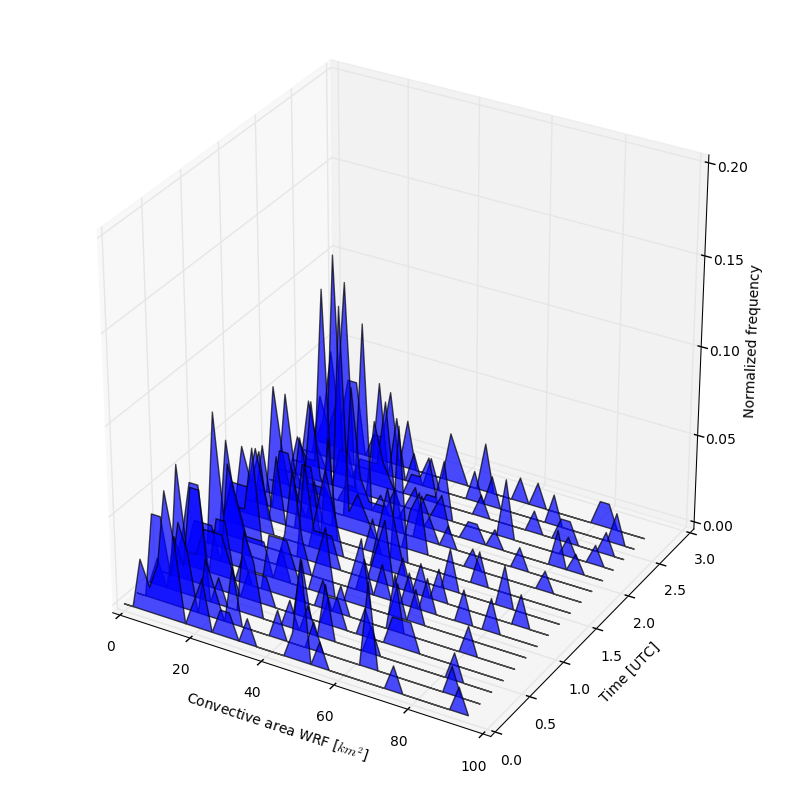

In [21]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = np.arange(0, 100, 2.5)
verts = []
zs = np.arange(0, len(times), 1.0)
i = 0
for z in zs:
    ys, bins = np.histogram(conv_area_wrf[i], bins=xs, normed=True)
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))
    i = i + 1

poly = PolyCollection(verts)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs/6, zdir='y')

ax.set_xlabel('Convective area WRF [$km^{2}$]')
ax.set_xlim3d(0, 100)
ax.set_ylabel('Time [UTC]')
ax.set_ylim3d(0, 3)
ax.set_zlabel('Normalized frequency')
ax.set_zlim3d(0, 0.2)

plt.show()

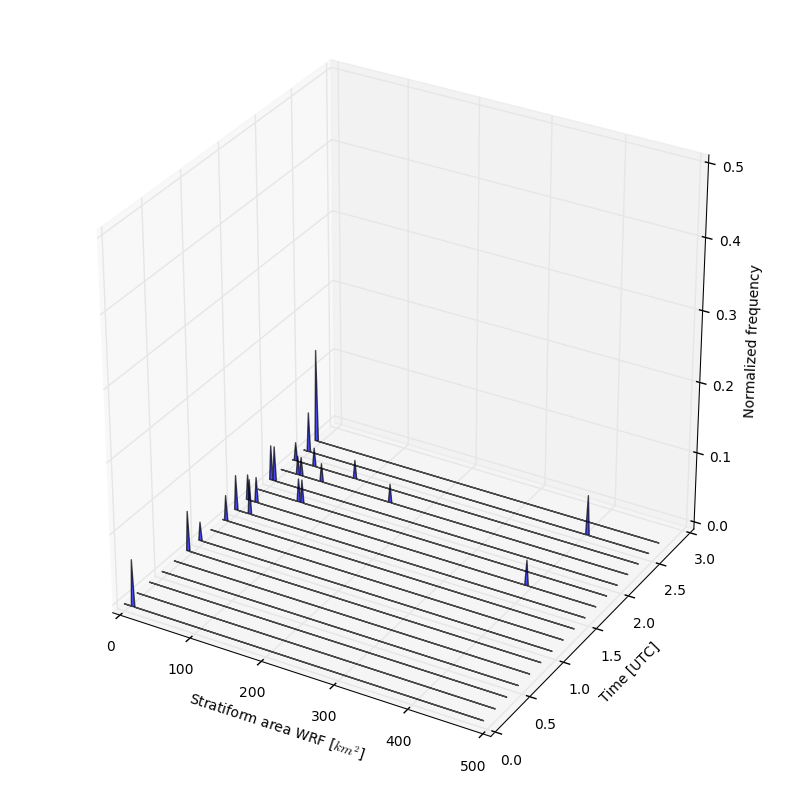

In [9]:
from matplotlib import colors as mcolors
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

xs = np.arange(0, 500, 2.5)
verts = []
zs = np.arange(0, len(times), 1.0)
i = 0
for z in zs:
    ys, bins = np.histogram(strat_area_wrf[i], bins=xs, normed=True)
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))
    i = i + 1

poly = PolyCollection(verts)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs/6, zdir='y')

ax.set_xlabel('Stratiform area WRF [$km^{2}$]')
ax.set_xlim3d(0, 500)
ax.set_ylabel('Time [UTC]')
ax.set_ylim3d(0, 3)
ax.set_zlabel('Normalized frequency')
ax.set_zlim3d(0, 0.5)

plt.show()